In [ ]:
!pip install transformers datasets accelerate matplotlib

In [ ]:
#IMPORTS:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering
from torch.optim import AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import default_data_collator
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
import random

In [ ]:
#DEFINITIONS:
def prepare_train_features(examples):
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized_examples.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        if len(answers["answer_start"]) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                start_positions.append(token_start_index - 1)

                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                end_positions.append(token_end_index + 1)

    tokenized_examples["start_positions"] = start_positions
    tokenized_examples["end_positions"] = end_positions
    return tokenized_examples


In [ ]:
drive.mount('/content/drive')
# Load dataset
squad = load_dataset("squad")

# Load tokenizer and model
#tokenizer = DistilBertTokenizerFast.from_pretrained("/content/drive/My Drive/Distil-BERT/QA/Model5")
#model = DistilBertForQuestionAnswering.from_pretrained("/content/drive/My Drive/Distil-BERT/QA/Model5")
tokenizer = DistilBertTokenizerFast.from_pretrained("/content/drive/My Drive/Colab Notebooks/Distil-BERT/QA/Model10")
model = DistilBertForQuestionAnswering.from_pretrained("/content/drive/My Drive/Colab Notebooks/Distil-BERT/QA/Model10")

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training
model.train()
save_every = 4
for count in range(11,20):
    seed1 = random.randint(1,1000)
    batch_num = 0
    totalLoss = 0;
    LossVector = []
    for epoch in range(3):
        small_train = squad["train"].shuffle(seed=seed1).select(range(1000))

    # Tokenize the reduced dataset
        tokenized_squad = small_train.map(
            prepare_train_features,
            batched=True,
            remove_columns=small_train.column_names
        )


    # DataLoader
        train_loader = DataLoader(tokenized_squad, batch_size=16, shuffle=True, collate_fn=default_data_collator)
        progress = tqdm(train_loader)
        for batch in progress:
            batch_num += 1

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions,
                end_positions=end_positions,
            )

            loss = outputs.loss
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            totalLoss += loss.item()
            LossVector.append(loss.item())
            avg = totalLoss / batch_num

            progress.set_description(f"Loss: {avg:.4f}")
    count += 1
    #save_path = f"/content/drive/My Drive/Distil-BERT/QA/Model" + str(count)
    save_path = f"/content/drive/My Drive/Colab Notebooks/Distil-BERT/QA/Model" + str(count)
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"Model saved at {save_path}")
    print(f"Model {count} Loss Vector: {LossVector}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loss: 0.9710: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]


[2.19028902053833, 0.5260574817657471, 1.590043067932129, 0.6233518123626709, 0.6648296117782593, 1.5940337181091309, 0.565818727016449, 0.9644250273704529, 0.8639694452285767, 1.1058404445648193, 0.8664034605026245, 1.2793395519256592, 0.8580405712127686, 0.7660409212112427, 1.583303451538086, 0.6643420457839966, 0.8218334913253784, 0.5290156602859497, 1.828493595123291, 1.0335519313812256, 1.1467646360397339, 0.9281312227249146, 0.551889955997467, 0.3895394802093506, 0.8069971203804016, 0.879178524017334, 0.8747413158416748, 0.963691234588623, 1.7324562072753906, 0.8443149328231812, 0.9150637984275818, 1.117969036102295, 1.1975674629211426, 0.5129699110984802, 0.76948082447052, 1.1893078088760376, 1.0811960697174072, 0.9665113687515259, 1.0279781818389893, 0.7788828015327454, 0.776282548904419, 0.32250097393989563, 0.45445239543914795, 1.0851444005966187, 0.8131449222564697, 1.1326501369476318, 1.0556998252868652, 0.9302083849906921, 0.624738335609436, 1.002716064453125, 0.8651633858

Loss: 0.6972: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]


[2.19028902053833, 0.5260574817657471, 1.590043067932129, 0.6233518123626709, 0.6648296117782593, 1.5940337181091309, 0.565818727016449, 0.9644250273704529, 0.8639694452285767, 1.1058404445648193, 0.8664034605026245, 1.2793395519256592, 0.8580405712127686, 0.7660409212112427, 1.583303451538086, 0.6643420457839966, 0.8218334913253784, 0.5290156602859497, 1.828493595123291, 1.0335519313812256, 1.1467646360397339, 0.9281312227249146, 0.551889955997467, 0.3895394802093506, 0.8069971203804016, 0.879178524017334, 0.8747413158416748, 0.963691234588623, 1.7324562072753906, 0.8443149328231812, 0.9150637984275818, 1.117969036102295, 1.1975674629211426, 0.5129699110984802, 0.76948082447052, 1.1893078088760376, 1.0811960697174072, 0.9665113687515259, 1.0279781818389893, 0.7788828015327454, 0.776282548904419, 0.32250097393989563, 0.45445239543914795, 1.0851444005966187, 0.8131449222564697, 1.1326501369476318, 1.0556998252868652, 0.9302083849906921, 0.624738335609436, 1.002716064453125, 0.8651633858

Loss: 0.5253: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


[2.19028902053833, 0.5260574817657471, 1.590043067932129, 0.6233518123626709, 0.6648296117782593, 1.5940337181091309, 0.565818727016449, 0.9644250273704529, 0.8639694452285767, 1.1058404445648193, 0.8664034605026245, 1.2793395519256592, 0.8580405712127686, 0.7660409212112427, 1.583303451538086, 0.6643420457839966, 0.8218334913253784, 0.5290156602859497, 1.828493595123291, 1.0335519313812256, 1.1467646360397339, 0.9281312227249146, 0.551889955997467, 0.3895394802093506, 0.8069971203804016, 0.879178524017334, 0.8747413158416748, 0.963691234588623, 1.7324562072753906, 0.8443149328231812, 0.9150637984275818, 1.117969036102295, 1.1975674629211426, 0.5129699110984802, 0.76948082447052, 1.1893078088760376, 1.0811960697174072, 0.9665113687515259, 1.0279781818389893, 0.7788828015327454, 0.776282548904419, 0.32250097393989563, 0.45445239543914795, 1.0851444005966187, 0.8131449222564697, 1.1326501369476318, 1.0556998252868652, 0.9302083849906921, 0.624738335609436, 1.002716064453125, 0.8651633858

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loss: 1.0807: 100%|██████████| 64/64 [00:35<00:00,  1.78it/s]


[2.8356809616088867, 1.5768301486968994, 0.6011075377464294, 1.4223930835723877, 1.0303199291229248, 1.2882808446884155, 1.0919594764709473, 0.5524036884307861, 0.674912691116333, 1.365807056427002, 1.695408821105957, 1.0084936618804932, 1.2545242309570312, 0.7961900234222412, 0.7696669697761536, 1.3427050113677979, 0.7731993794441223, 0.9927908182144165, 0.4678102731704712, 0.5167236328125, 1.2557045221328735, 1.3110928535461426, 1.4164115190505981, 1.1641157865524292, 1.2663533687591553, 1.225234866142273, 1.1062355041503906, 1.248431921005249, 0.7579147815704346, 0.3814147114753723, 1.1160260438919067, 1.0367871522903442, 0.8945789337158203, 1.1021407842636108, 1.2006374597549438, 1.1951179504394531, 0.882793664932251, 1.3578579425811768, 0.7648138999938965, 1.0014429092407227, 0.9713322520256042, 0.8282784223556519, 0.8912514448165894, 1.389425277709961, 0.9210449457168579, 0.8630231618881226, 1.072632074356079, 1.1302635669708252, 0.9195854067802429, 1.197273850440979, 0.529771089

Loss: 0.7184: 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


[2.8356809616088867, 1.5768301486968994, 0.6011075377464294, 1.4223930835723877, 1.0303199291229248, 1.2882808446884155, 1.0919594764709473, 0.5524036884307861, 0.674912691116333, 1.365807056427002, 1.695408821105957, 1.0084936618804932, 1.2545242309570312, 0.7961900234222412, 0.7696669697761536, 1.3427050113677979, 0.7731993794441223, 0.9927908182144165, 0.4678102731704712, 0.5167236328125, 1.2557045221328735, 1.3110928535461426, 1.4164115190505981, 1.1641157865524292, 1.2663533687591553, 1.225234866142273, 1.1062355041503906, 1.248431921005249, 0.7579147815704346, 0.3814147114753723, 1.1160260438919067, 1.0367871522903442, 0.8945789337158203, 1.1021407842636108, 1.2006374597549438, 1.1951179504394531, 0.882793664932251, 1.3578579425811768, 0.7648138999938965, 1.0014429092407227, 0.9713322520256042, 0.8282784223556519, 0.8912514448165894, 1.389425277709961, 0.9210449457168579, 0.8630231618881226, 1.072632074356079, 1.1302635669708252, 0.9195854067802429, 1.197273850440979, 0.529771089

Loss: 0.5241: 100%|██████████| 64/64 [00:35<00:00,  1.83it/s]


[2.8356809616088867, 1.5768301486968994, 0.6011075377464294, 1.4223930835723877, 1.0303199291229248, 1.2882808446884155, 1.0919594764709473, 0.5524036884307861, 0.674912691116333, 1.365807056427002, 1.695408821105957, 1.0084936618804932, 1.2545242309570312, 0.7961900234222412, 0.7696669697761536, 1.3427050113677979, 0.7731993794441223, 0.9927908182144165, 0.4678102731704712, 0.5167236328125, 1.2557045221328735, 1.3110928535461426, 1.4164115190505981, 1.1641157865524292, 1.2663533687591553, 1.225234866142273, 1.1062355041503906, 1.248431921005249, 0.7579147815704346, 0.3814147114753723, 1.1160260438919067, 1.0367871522903442, 0.8945789337158203, 1.1021407842636108, 1.2006374597549438, 1.1951179504394531, 0.882793664932251, 1.3578579425811768, 0.7648138999938965, 1.0014429092407227, 0.9713322520256042, 0.8282784223556519, 0.8912514448165894, 1.389425277709961, 0.9210449457168579, 0.8630231618881226, 1.072632074356079, 1.1302635669708252, 0.9195854067802429, 1.197273850440979, 0.529771089

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loss: 0.9752: 100%|██████████| 64/64 [00:36<00:00,  1.77it/s]


[1.4416230916976929, 0.7006516456604004, 0.6328475475311279, 0.7684831619262695, 1.1709091663360596, 1.5646547079086304, 0.6523370742797852, 0.8009224534034729, 1.2956657409667969, 0.8745416402816772, 0.6855394244194031, 1.4981287717819214, 1.0500072240829468, 1.0941996574401855, 1.4813997745513916, 0.9132832288742065, 0.6754253506660461, 0.6886402368545532, 0.7666333913803101, 0.8540924191474915, 0.9601200819015503, 1.516289472579956, 1.0013827085494995, 0.3668791651725769, 0.9298250675201416, 0.9656184911727905, 0.9747240543365479, 0.8682389259338379, 0.6286070942878723, 0.9384796619415283, 1.40199875831604, 1.2004314661026, 1.168787956237793, 1.3398432731628418, 0.6959725618362427, 0.9261521100997925, 1.3604925870895386, 1.4776203632354736, 1.3246872425079346, 0.9069368839263916, 0.8814992308616638, 1.2713327407836914, 0.7984205484390259, 0.7827247381210327, 0.660075306892395, 0.7313023805618286, 0.9703626036643982, 1.379181981086731, 0.8622355461120605, 0.6751092076301575, 1.385122

Loss: 0.6470: 100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


[1.4416230916976929, 0.7006516456604004, 0.6328475475311279, 0.7684831619262695, 1.1709091663360596, 1.5646547079086304, 0.6523370742797852, 0.8009224534034729, 1.2956657409667969, 0.8745416402816772, 0.6855394244194031, 1.4981287717819214, 1.0500072240829468, 1.0941996574401855, 1.4813997745513916, 0.9132832288742065, 0.6754253506660461, 0.6886402368545532, 0.7666333913803101, 0.8540924191474915, 0.9601200819015503, 1.516289472579956, 1.0013827085494995, 0.3668791651725769, 0.9298250675201416, 0.9656184911727905, 0.9747240543365479, 0.8682389259338379, 0.6286070942878723, 0.9384796619415283, 1.40199875831604, 1.2004314661026, 1.168787956237793, 1.3398432731628418, 0.6959725618362427, 0.9261521100997925, 1.3604925870895386, 1.4776203632354736, 1.3246872425079346, 0.9069368839263916, 0.8814992308616638, 1.2713327407836914, 0.7984205484390259, 0.7827247381210327, 0.660075306892395, 0.7313023805618286, 0.9703626036643982, 1.379181981086731, 0.8622355461120605, 0.6751092076301575, 1.385122

Loss: 0.4781: 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]


[1.4416230916976929, 0.7006516456604004, 0.6328475475311279, 0.7684831619262695, 1.1709091663360596, 1.5646547079086304, 0.6523370742797852, 0.8009224534034729, 1.2956657409667969, 0.8745416402816772, 0.6855394244194031, 1.4981287717819214, 1.0500072240829468, 1.0941996574401855, 1.4813997745513916, 0.9132832288742065, 0.6754253506660461, 0.6886402368545532, 0.7666333913803101, 0.8540924191474915, 0.9601200819015503, 1.516289472579956, 1.0013827085494995, 0.3668791651725769, 0.9298250675201416, 0.9656184911727905, 0.9747240543365479, 0.8682389259338379, 0.6286070942878723, 0.9384796619415283, 1.40199875831604, 1.2004314661026, 1.168787956237793, 1.3398432731628418, 0.6959725618362427, 0.9261521100997925, 1.3604925870895386, 1.4776203632354736, 1.3246872425079346, 0.9069368839263916, 0.8814992308616638, 1.2713327407836914, 0.7984205484390259, 0.7827247381210327, 0.660075306892395, 0.7313023805618286, 0.9703626036643982, 1.379181981086731, 0.8622355461120605, 0.6751092076301575, 1.385122

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loss: 0.9594: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


[1.4691097736358643, 2.4306745529174805, 1.005159854888916, 1.117992639541626, 1.4229439496994019, 0.860155463218689, 0.9295414686203003, 0.19611303508281708, 0.7363976240158081, 1.4501023292541504, 1.2624320983886719, 1.5420560836791992, 0.7590174674987793, 0.9318325519561768, 0.967556357383728, 0.9618395566940308, 0.8439598679542542, 1.0133870840072632, 0.8547098636627197, 0.6212348937988281, 0.9442126750946045, 0.5211492776870728, 1.0495357513427734, 0.567504346370697, 0.9909196496009827, 0.8819565773010254, 1.0190351009368896, 1.0172159671783447, 0.5229910016059875, 0.6419081091880798, 0.9778231382369995, 0.9570814371109009, 0.7860585451126099, 0.8553441762924194, 0.8485100269317627, 0.9708666205406189, 1.1083874702453613, 1.4145514965057373, 1.0256694555282593, 0.7488570213317871, 0.7404608726501465, 0.9044979810714722, 1.2507643699645996, 0.8117461204528809, 0.3611454367637634, 0.6116325855255127, 1.0664732456207275, 0.7561196684837341, 0.606227457523346, 0.9758281707763672, 1.00

Loss: 0.6230: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s]


[1.4691097736358643, 2.4306745529174805, 1.005159854888916, 1.117992639541626, 1.4229439496994019, 0.860155463218689, 0.9295414686203003, 0.19611303508281708, 0.7363976240158081, 1.4501023292541504, 1.2624320983886719, 1.5420560836791992, 0.7590174674987793, 0.9318325519561768, 0.967556357383728, 0.9618395566940308, 0.8439598679542542, 1.0133870840072632, 0.8547098636627197, 0.6212348937988281, 0.9442126750946045, 0.5211492776870728, 1.0495357513427734, 0.567504346370697, 0.9909196496009827, 0.8819565773010254, 1.0190351009368896, 1.0172159671783447, 0.5229910016059875, 0.6419081091880798, 0.9778231382369995, 0.9570814371109009, 0.7860585451126099, 0.8553441762924194, 0.8485100269317627, 0.9708666205406189, 1.1083874702453613, 1.4145514965057373, 1.0256694555282593, 0.7488570213317871, 0.7404608726501465, 0.9044979810714722, 1.2507643699645996, 0.8117461204528809, 0.3611454367637634, 0.6116325855255127, 1.0664732456207275, 0.7561196684837341, 0.606227457523346, 0.9758281707763672, 1.00

Loss: 0.4537: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s]


[1.4691097736358643, 2.4306745529174805, 1.005159854888916, 1.117992639541626, 1.4229439496994019, 0.860155463218689, 0.9295414686203003, 0.19611303508281708, 0.7363976240158081, 1.4501023292541504, 1.2624320983886719, 1.5420560836791992, 0.7590174674987793, 0.9318325519561768, 0.967556357383728, 0.9618395566940308, 0.8439598679542542, 1.0133870840072632, 0.8547098636627197, 0.6212348937988281, 0.9442126750946045, 0.5211492776870728, 1.0495357513427734, 0.567504346370697, 0.9909196496009827, 0.8819565773010254, 1.0190351009368896, 1.0172159671783447, 0.5229910016059875, 0.6419081091880798, 0.9778231382369995, 0.9570814371109009, 0.7860585451126099, 0.8553441762924194, 0.8485100269317627, 0.9708666205406189, 1.1083874702453613, 1.4145514965057373, 1.0256694555282593, 0.7488570213317871, 0.7404608726501465, 0.9044979810714722, 1.2507643699645996, 0.8117461204528809, 0.3611454367637634, 0.6116325855255127, 1.0664732456207275, 0.7561196684837341, 0.606227457523346, 0.9758281707763672, 1.00

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loss: 0.9782: 100%|██████████| 63/63 [00:35<00:00,  1.80it/s]


[1.3096035718917847, 0.9655026197433472, 1.394296646118164, 1.0149776935577393, 2.5295348167419434, 1.4248898029327393, 2.137178659439087, 0.5424810647964478, 1.0226222276687622, 0.6658554077148438, 0.4778049886226654, 1.1694482564926147, 0.7177944183349609, 0.6151691675186157, 0.6197338104248047, 1.2862679958343506, 0.8060951828956604, 0.7054558992385864, 0.7124074697494507, 0.8787527680397034, 1.8016990423202515, 1.248612642288208, 1.095564365386963, 1.4540024995803833, 0.6851736307144165, 0.9751885533332825, 1.1158721446990967, 0.9311517477035522, 1.201395034790039, 1.3042409420013428, 1.044724941253662, 0.8630416393280029, 0.4594178795814514, 0.7915437817573547, 0.4651135206222534, 1.0946168899536133, 0.5355916619300842, 1.1236274242401123, 1.0349385738372803, 0.841667890548706, 0.7212976217269897, 0.7309422492980957, 0.7570144534111023, 1.0782850980758667, 1.4716465473175049, 0.8267799019813538, 1.0936130285263062, 0.898551344871521, 0.3184868395328522, 0.7079419493675232, 1.41590

Loss: 0.6452: 100%|██████████| 63/63 [00:35<00:00,  1.80it/s]


[1.3096035718917847, 0.9655026197433472, 1.394296646118164, 1.0149776935577393, 2.5295348167419434, 1.4248898029327393, 2.137178659439087, 0.5424810647964478, 1.0226222276687622, 0.6658554077148438, 0.4778049886226654, 1.1694482564926147, 0.7177944183349609, 0.6151691675186157, 0.6197338104248047, 1.2862679958343506, 0.8060951828956604, 0.7054558992385864, 0.7124074697494507, 0.8787527680397034, 1.8016990423202515, 1.248612642288208, 1.095564365386963, 1.4540024995803833, 0.6851736307144165, 0.9751885533332825, 1.1158721446990967, 0.9311517477035522, 1.201395034790039, 1.3042409420013428, 1.044724941253662, 0.8630416393280029, 0.4594178795814514, 0.7915437817573547, 0.4651135206222534, 1.0946168899536133, 0.5355916619300842, 1.1236274242401123, 1.0349385738372803, 0.841667890548706, 0.7212976217269897, 0.7309422492980957, 0.7570144534111023, 1.0782850980758667, 1.4716465473175049, 0.8267799019813538, 1.0936130285263062, 0.898551344871521, 0.3184868395328522, 0.7079419493675232, 1.41590

Loss: 0.4654: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s]


[1.3096035718917847, 0.9655026197433472, 1.394296646118164, 1.0149776935577393, 2.5295348167419434, 1.4248898029327393, 2.137178659439087, 0.5424810647964478, 1.0226222276687622, 0.6658554077148438, 0.4778049886226654, 1.1694482564926147, 0.7177944183349609, 0.6151691675186157, 0.6197338104248047, 1.2862679958343506, 0.8060951828956604, 0.7054558992385864, 0.7124074697494507, 0.8787527680397034, 1.8016990423202515, 1.248612642288208, 1.095564365386963, 1.4540024995803833, 0.6851736307144165, 0.9751885533332825, 1.1158721446990967, 0.9311517477035522, 1.201395034790039, 1.3042409420013428, 1.044724941253662, 0.8630416393280029, 0.4594178795814514, 0.7915437817573547, 0.4651135206222534, 1.0946168899536133, 0.5355916619300842, 1.1236274242401123, 1.0349385738372803, 0.841667890548706, 0.7212976217269897, 0.7309422492980957, 0.7570144534111023, 1.0782850980758667, 1.4716465473175049, 0.8267799019813538, 1.0936130285263062, 0.898551344871521, 0.3184868395328522, 0.7079419493675232, 1.41590

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loss: 1.0353: 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


[1.0057430267333984, 0.7559117078781128, 0.8801233768463135, 1.9057344198226929, 0.9017671346664429, 1.6848876476287842, 0.7926174998283386, 1.755561351776123, 2.0362467765808105, 0.6040117740631104, 0.700020432472229, 0.5959243178367615, 0.9570249915122986, 1.108628273010254, 1.1050293445587158, 0.5687558650970459, 1.3493553400039673, 1.1597341299057007, 1.5787289142608643, 0.8334641456604004, 1.5065137147903442, 0.579534113407135, 1.0242226123809814, 1.362297534942627, 0.6481373310089111, 0.5227296948432922, 0.9927554130554199, 1.2346680164337158, 1.316436529159546, 0.9015023708343506, 0.6081598401069641, 0.8515958786010742, 0.35563015937805176, 0.6140735745429993, 1.0814611911773682, 0.360696941614151, 0.7193491458892822, 0.9012256264686584, 0.8445647954940796, 1.132131576538086, 0.959370493888855, 0.7278669476509094, 1.7856208086013794, 0.6762646436691284, 0.8953791260719299, 1.0152751207351685, 0.6779195666313171, 0.8346372246742249, 1.0420410633087158, 0.6342852115631104, 0.59123

Loss: 0.7019: 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


[1.0057430267333984, 0.7559117078781128, 0.8801233768463135, 1.9057344198226929, 0.9017671346664429, 1.6848876476287842, 0.7926174998283386, 1.755561351776123, 2.0362467765808105, 0.6040117740631104, 0.700020432472229, 0.5959243178367615, 0.9570249915122986, 1.108628273010254, 1.1050293445587158, 0.5687558650970459, 1.3493553400039673, 1.1597341299057007, 1.5787289142608643, 0.8334641456604004, 1.5065137147903442, 0.579534113407135, 1.0242226123809814, 1.362297534942627, 0.6481373310089111, 0.5227296948432922, 0.9927554130554199, 1.2346680164337158, 1.316436529159546, 0.9015023708343506, 0.6081598401069641, 0.8515958786010742, 0.35563015937805176, 0.6140735745429993, 1.0814611911773682, 0.360696941614151, 0.7193491458892822, 0.9012256264686584, 0.8445647954940796, 1.132131576538086, 0.959370493888855, 0.7278669476509094, 1.7856208086013794, 0.6762646436691284, 0.8953791260719299, 1.0152751207351685, 0.6779195666313171, 0.8346372246742249, 1.0420410633087158, 0.6342852115631104, 0.59123

Loss: 0.5109: 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]


[1.0057430267333984, 0.7559117078781128, 0.8801233768463135, 1.9057344198226929, 0.9017671346664429, 1.6848876476287842, 0.7926174998283386, 1.755561351776123, 2.0362467765808105, 0.6040117740631104, 0.700020432472229, 0.5959243178367615, 0.9570249915122986, 1.108628273010254, 1.1050293445587158, 0.5687558650970459, 1.3493553400039673, 1.1597341299057007, 1.5787289142608643, 0.8334641456604004, 1.5065137147903442, 0.579534113407135, 1.0242226123809814, 1.362297534942627, 0.6481373310089111, 0.5227296948432922, 0.9927554130554199, 1.2346680164337158, 1.316436529159546, 0.9015023708343506, 0.6081598401069641, 0.8515958786010742, 0.35563015937805176, 0.6140735745429993, 1.0814611911773682, 0.360696941614151, 0.7193491458892822, 0.9012256264686584, 0.8445647954940796, 1.132131576538086, 0.959370493888855, 0.7278669476509094, 1.7856208086013794, 0.6762646436691284, 0.8953791260719299, 1.0152751207351685, 0.6779195666313171, 0.8346372246742249, 1.0420410633087158, 0.6342852115631104, 0.59123

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loss: 0.9358: 100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


[0.6881759166717529, 0.8530024886131287, 1.1122429370880127, 0.460486501455307, 1.3345916271209717, 1.0380795001983643, 0.978503942489624, 1.228139877319336, 1.246802806854248, 0.9229778051376343, 1.132521629333496, 1.1665019989013672, 1.4155635833740234, 0.8938683867454529, 1.1328027248382568, 0.6762543320655823, 1.2584662437438965, 0.5905478000640869, 1.238168716430664, 0.7822446823120117, 1.7590709924697876, 0.4104073643684387, 0.9425917863845825, 0.7204483151435852, 1.3961689472198486, 1.363842487335205, 0.45600026845932007, 0.5697278380393982, 1.5330097675323486, 0.6277654767036438, 1.351111650466919, 0.7045319080352783, 1.1986981630325317, 1.0204523801803589, 0.5176553726196289, 1.056718349456787, 0.975833535194397, 0.9616823196411133, 0.7547285556793213, 1.6087207794189453, 0.5394995212554932, 0.9911774396896362, 0.4458697438240051, 1.1823554039001465, 0.9454953074455261, 0.6698036193847656, 1.0059092044830322, 0.27861496806144714, 1.347947359085083, 0.695649266242981, 1.1454923

Loss: 0.6260: 100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


[0.6881759166717529, 0.8530024886131287, 1.1122429370880127, 0.460486501455307, 1.3345916271209717, 1.0380795001983643, 0.978503942489624, 1.228139877319336, 1.246802806854248, 0.9229778051376343, 1.132521629333496, 1.1665019989013672, 1.4155635833740234, 0.8938683867454529, 1.1328027248382568, 0.6762543320655823, 1.2584662437438965, 0.5905478000640869, 1.238168716430664, 0.7822446823120117, 1.7590709924697876, 0.4104073643684387, 0.9425917863845825, 0.7204483151435852, 1.3961689472198486, 1.363842487335205, 0.45600026845932007, 0.5697278380393982, 1.5330097675323486, 0.6277654767036438, 1.351111650466919, 0.7045319080352783, 1.1986981630325317, 1.0204523801803589, 0.5176553726196289, 1.056718349456787, 0.975833535194397, 0.9616823196411133, 0.7547285556793213, 1.6087207794189453, 0.5394995212554932, 0.9911774396896362, 0.4458697438240051, 1.1823554039001465, 0.9454953074455261, 0.6698036193847656, 1.0059092044830322, 0.27861496806144714, 1.347947359085083, 0.695649266242981, 1.1454923

Loss: 0.4558: 100%|██████████| 64/64 [00:35<00:00,  1.83it/s]


[0.6881759166717529, 0.8530024886131287, 1.1122429370880127, 0.460486501455307, 1.3345916271209717, 1.0380795001983643, 0.978503942489624, 1.228139877319336, 1.246802806854248, 0.9229778051376343, 1.132521629333496, 1.1665019989013672, 1.4155635833740234, 0.8938683867454529, 1.1328027248382568, 0.6762543320655823, 1.2584662437438965, 0.5905478000640869, 1.238168716430664, 0.7822446823120117, 1.7590709924697876, 0.4104073643684387, 0.9425917863845825, 0.7204483151435852, 1.3961689472198486, 1.363842487335205, 0.45600026845932007, 0.5697278380393982, 1.5330097675323486, 0.6277654767036438, 1.351111650466919, 0.7045319080352783, 1.1986981630325317, 1.0204523801803589, 0.5176553726196289, 1.056718349456787, 0.975833535194397, 0.9616823196411133, 0.7547285556793213, 1.6087207794189453, 0.5394995212554932, 0.9911774396896362, 0.4458697438240051, 1.1823554039001465, 0.9454953074455261, 0.6698036193847656, 1.0059092044830322, 0.27861496806144714, 1.347947359085083, 0.695649266242981, 1.1454923

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loss: 1.0856: 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


[0.9699288606643677, 1.3471245765686035, 0.6810624003410339, 0.8190182447433472, 1.0117322206497192, 0.5898563265800476, 1.0990034341812134, 0.4363122582435608, 1.3516602516174316, 0.8324545621871948, 1.0839629173278809, 0.9919515252113342, 1.3098187446594238, 0.8695341348648071, 1.4079453945159912, 1.6656525135040283, 0.7487280368804932, 0.7237877249717712, 0.8948863744735718, 0.8348245024681091, 1.3626744747161865, 0.4572429656982422, 1.2397358417510986, 0.9871246218681335, 1.7955811023712158, 1.0084986686706543, 1.5693354606628418, 1.6990814208984375, 1.618032455444336, 0.9694665670394897, 0.737547755241394, 1.514962911605835, 0.4637413024902344, 0.942221999168396, 1.1551978588104248, 0.7042176723480225, 0.6561148762702942, 1.361996054649353, 0.9920896291732788, 0.964606523513794, 1.1678181886672974, 1.2972561120986938, 0.6887843012809753, 1.5080432891845703, 1.349219799041748, 0.8722021579742432, 1.0557758808135986, 1.020808219909668, 1.776702880859375, 1.591900110244751, 0.8838388

Loss: 0.7099: 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


[0.9699288606643677, 1.3471245765686035, 0.6810624003410339, 0.8190182447433472, 1.0117322206497192, 0.5898563265800476, 1.0990034341812134, 0.4363122582435608, 1.3516602516174316, 0.8324545621871948, 1.0839629173278809, 0.9919515252113342, 1.3098187446594238, 0.8695341348648071, 1.4079453945159912, 1.6656525135040283, 0.7487280368804932, 0.7237877249717712, 0.8948863744735718, 0.8348245024681091, 1.3626744747161865, 0.4572429656982422, 1.2397358417510986, 0.9871246218681335, 1.7955811023712158, 1.0084986686706543, 1.5693354606628418, 1.6990814208984375, 1.618032455444336, 0.9694665670394897, 0.737547755241394, 1.514962911605835, 0.4637413024902344, 0.942221999168396, 1.1551978588104248, 0.7042176723480225, 0.6561148762702942, 1.361996054649353, 0.9920896291732788, 0.964606523513794, 1.1678181886672974, 1.2972561120986938, 0.6887843012809753, 1.5080432891845703, 1.349219799041748, 0.8722021579742432, 1.0557758808135986, 1.020808219909668, 1.776702880859375, 1.591900110244751, 0.8838388

Loss: 0.5110: 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


[0.9699288606643677, 1.3471245765686035, 0.6810624003410339, 0.8190182447433472, 1.0117322206497192, 0.5898563265800476, 1.0990034341812134, 0.4363122582435608, 1.3516602516174316, 0.8324545621871948, 1.0839629173278809, 0.9919515252113342, 1.3098187446594238, 0.8695341348648071, 1.4079453945159912, 1.6656525135040283, 0.7487280368804932, 0.7237877249717712, 0.8948863744735718, 0.8348245024681091, 1.3626744747161865, 0.4572429656982422, 1.2397358417510986, 0.9871246218681335, 1.7955811023712158, 1.0084986686706543, 1.5693354606628418, 1.6990814208984375, 1.618032455444336, 0.9694665670394897, 0.737547755241394, 1.514962911605835, 0.4637413024902344, 0.942221999168396, 1.1551978588104248, 0.7042176723480225, 0.6561148762702942, 1.361996054649353, 0.9920896291732788, 0.964606523513794, 1.1678181886672974, 1.2972561120986938, 0.6887843012809753, 1.5080432891845703, 1.349219799041748, 0.8722021579742432, 1.0557758808135986, 1.020808219909668, 1.776702880859375, 1.591900110244751, 0.8838388

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loss: 1.0882: 100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


[1.5871940851211548, 0.4586344063282013, 1.2690973281860352, 1.674208641052246, 1.8152507543563843, 0.9983734488487244, 1.5768558979034424, 0.9856914281845093, 1.3631813526153564, 1.7084460258483887, 1.1076626777648926, 1.077734112739563, 2.564584255218506, 1.2588999271392822, 1.2414894104003906, 1.3210186958312988, 0.9393762350082397, 1.0182807445526123, 0.721180260181427, 1.1473114490509033, 1.3076881170272827, 1.2853829860687256, 0.6304100751876831, 0.9256691932678223, 0.915354311466217, 0.8327160477638245, 0.9126487970352173, 1.431254506111145, 0.6820908784866333, 0.3562241196632385, 0.7363290786743164, 1.3303627967834473, 0.6557614803314209, 1.731952428817749, 0.9005632996559143, 0.5659255981445312, 0.8210796117782593, 0.7568681240081787, 1.3475232124328613, 1.2220878601074219, 0.652095377445221, 1.0620861053466797, 1.174973964691162, 1.4095146656036377, 0.9526141285896301, 0.7559365034103394, 1.0237551927566528, 1.176540732383728, 1.483431100845337, 0.9429502487182617, 0.72500574

Loss: 0.7072: 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


[1.5871940851211548, 0.4586344063282013, 1.2690973281860352, 1.674208641052246, 1.8152507543563843, 0.9983734488487244, 1.5768558979034424, 0.9856914281845093, 1.3631813526153564, 1.7084460258483887, 1.1076626777648926, 1.077734112739563, 2.564584255218506, 1.2588999271392822, 1.2414894104003906, 1.3210186958312988, 0.9393762350082397, 1.0182807445526123, 0.721180260181427, 1.1473114490509033, 1.3076881170272827, 1.2853829860687256, 0.6304100751876831, 0.9256691932678223, 0.915354311466217, 0.8327160477638245, 0.9126487970352173, 1.431254506111145, 0.6820908784866333, 0.3562241196632385, 0.7363290786743164, 1.3303627967834473, 0.6557614803314209, 1.731952428817749, 0.9005632996559143, 0.5659255981445312, 0.8210796117782593, 0.7568681240081787, 1.3475232124328613, 1.2220878601074219, 0.652095377445221, 1.0620861053466797, 1.174973964691162, 1.4095146656036377, 0.9526141285896301, 0.7559365034103394, 1.0237551927566528, 1.176540732383728, 1.483431100845337, 0.9429502487182617, 0.72500574

Loss: 0.5149: 100%|██████████| 64/64 [00:35<00:00,  1.83it/s]


[1.5871940851211548, 0.4586344063282013, 1.2690973281860352, 1.674208641052246, 1.8152507543563843, 0.9983734488487244, 1.5768558979034424, 0.9856914281845093, 1.3631813526153564, 1.7084460258483887, 1.1076626777648926, 1.077734112739563, 2.564584255218506, 1.2588999271392822, 1.2414894104003906, 1.3210186958312988, 0.9393762350082397, 1.0182807445526123, 0.721180260181427, 1.1473114490509033, 1.3076881170272827, 1.2853829860687256, 0.6304100751876831, 0.9256691932678223, 0.915354311466217, 0.8327160477638245, 0.9126487970352173, 1.431254506111145, 0.6820908784866333, 0.3562241196632385, 0.7363290786743164, 1.3303627967834473, 0.6557614803314209, 1.731952428817749, 0.9005632996559143, 0.5659255981445312, 0.8210796117782593, 0.7568681240081787, 1.3475232124328613, 1.2220878601074219, 0.652095377445221, 1.0620861053466797, 1.174973964691162, 1.4095146656036377, 0.9526141285896301, 0.7559365034103394, 1.0237551927566528, 1.176540732383728, 1.483431100845337, 0.9429502487182617, 0.72500574

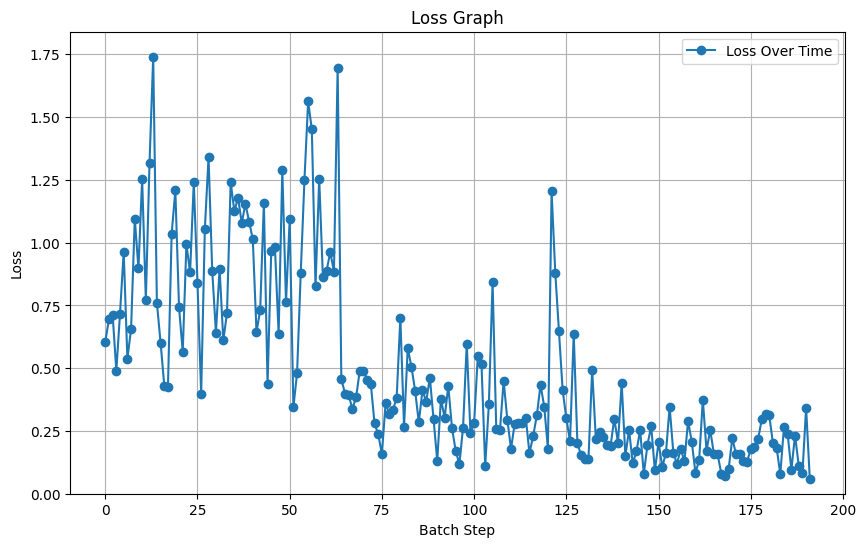

In [ ]:
LossVector = [0.6036608815193176, 0.6953475475311279, 0.7122277617454529, 0.49004414677619934, 0.7173977494239807, 0.9640514254570007, 0.5375427007675171, 0.6558915376663208, 1.0949697494506836, 0.8975297808647156, 1.2526321411132812, 0.7718744277954102, 1.3182440996170044, 1.7401280403137207, 0.7599726915359497, 0.6013151407241821, 0.4307655692100525, 0.4270564317703247, 1.0358233451843262, 1.2077698707580566, 0.7430063486099243, 0.5652590990066528, 0.9932474493980408, 0.8813902735710144, 1.2397098541259766, 0.8389221429824829, 0.39747288823127747, 1.054903268814087, 1.339782476425171, 0.8879643678665161, 0.6416682004928589, 0.8966537714004517, 0.6114922761917114, 0.718422532081604, 1.2417054176330566, 1.1247704029083252, 1.1795876026153564, 1.0780494213104248, 1.154346227645874, 1.082876443862915, 1.0130399465560913, 0.6444147825241089, 0.7304782271385193, 1.1583104133605957, 0.4361444413661957, 0.9670709371566772, 0.980726957321167, 0.6361804008483887, 1.2891303300857544, 0.7633465528488159, 1.094005823135376, 0.34425774216651917, 0.4800799489021301, 0.8811005353927612, 1.2497906684875488, 1.5629220008850098, 1.4511189460754395, 0.8260108828544617, 1.255053997039795, 0.8622468113899231, 0.8879363536834717, 0.9622023105621338, 0.8847346305847168, 1.6970385313034058, 0.4575049877166748, 0.3987078070640564, 0.3915339708328247, 0.3382652699947357, 0.38410770893096924, 0.4905495047569275, 0.49065476655960083, 0.452473521232605, 0.4358404278755188, 0.2797497510910034, 0.2368067502975464, 0.15867993235588074, 0.36099493503570557, 0.31767356395721436, 0.33312520384788513, 0.38278791308403015, 0.7012206315994263, 0.2673179507255554, 0.5791696906089783, 0.5061836242675781, 0.41085729002952576, 0.28462502360343933, 0.41258326172828674, 0.36640840768814087, 0.4623205065727234, 0.2968665361404419, 0.13128948211669922, 0.3778741955757141, 0.30300530791282654, 0.42903071641921997, 0.26102250814437866, 0.17157919704914093, 0.11795918643474579, 0.263751745223999, 0.5980192422866821, 0.2414746880531311, 0.28289973735809326, 0.548733651638031, 0.5147023797035217, 0.11191031336784363, 0.3571411073207855, 0.8444629311561584, 0.25963231921195984, 0.2518996000289917, 0.4495088458061218, 0.2951429486274719, 0.17879918217658997, 0.2794361114501953, 0.27994704246520996, 0.2802671194076538, 0.30316662788391113, 0.16090568900108337, 0.22962120175361633, 0.31194692850112915, 0.43380647897720337, 0.3473939299583435, 0.17952629923820496, 1.2040269374847412, 0.8801445960998535, 0.6477779150009155, 0.4117611348628998, 0.3004496991634369, 0.2087767869234085, 0.6374943256378174, 0.20056548714637756, 0.15308785438537598, 0.13772015273571014, 0.13863202929496765, 0.49411243200302124, 0.2170361876487732, 0.2465311586856842, 0.22425687313079834, 0.1925310492515564, 0.1915970742702484, 0.29949384927749634, 0.2025035321712494, 0.4401838183403015, 0.15101288259029388, 0.25467851758003235, 0.12059995532035828, 0.16846846044063568, 0.25278007984161377, 0.07854688912630081, 0.19574850797653198, 0.2689204812049866, 0.0927601158618927, 0.2050771415233612, 0.10698144137859344, 0.16198910772800446, 0.3462620675563812, 0.16364111006259918, 0.11820977181196213, 0.17955738306045532, 0.1286560297012329, 0.2892839312553406, 0.20717166364192963, 0.08317384123802185, 0.13375456631183624, 0.37405550479888916, 0.1720830202102661, 0.2534913420677185, 0.16007646918296814, 0.15786798298358917, 0.08030769228935242, 0.07244593650102615, 0.09967456012964249, 0.2211175113916397, 0.15676498413085938, 0.157626673579216, 0.130857914686203, 0.12787380814552307, 0.17799146473407745, 0.18740662932395935, 0.21788036823272705, 0.2989838421344757, 0.31920233368873596, 0.3123314380645752, 0.20129375159740448, 0.18367941677570343, 0.07809656858444214, 0.2662064731121063, 0.23638221621513367, 0.09571833163499832, 0.23180243372917175, 0.11208193004131317, 0.08255960792303085, 0.34202075004577637, 0.05818464607000351]

plt.figure(figsize=(10, 6))
plt.plot(range(len(LossVector)), LossVector, label="Loss Over Time", marker='o')  # <- Fixed this line
plt.title("Loss Graph")
plt.xlabel("Batch Step")
plt.ylabel("Loss")
plt.ylim(0, max(LossVector) + 0.1)  # Dynamic y-limit
plt.legend()
plt.grid(True)
plt.show()